# VIZBI Tutorial Session
### Part 2: Cytoscape, IPython, Docker, and reproducible network data visualization workflows

Tuesday, 3/24/2015


### Lesson 1: Introduction to cyREST

by [Keiichiro Ono](http://keiono.github.io/)

----

![](http://cl.ly/XohP/logo300.png)

![](http://ipython.org/_static/IPy_header.png)


## Welcome!
This is an introduction to cyREST and its basic API.  In this section, you will learn how to access Cytoscape through RESTful API.

### Prerequisites
* Basic knowledge of RESTful API
    * [This is a good introduction to REST](http://www.restapitutorial.com/)
* Basic Python skill - only basics, such as conditional statements, loops, basic data types.
* Basic knowledge of Cytoscape
    * Cytoscape data types - Networks, Tables, and Styles.

### System Requirments
This tutorial is tested on the following platform:

#### Client machine running Cytoscape
* [Java SE 8](http://www.oracle.com/technetwork/java/javase/downloads/jdk8-downloads-2133151.html)
* [Cytoscape 3.2.1](http://cytoscape.org/download.php)
* Latest version of [cyREST app](https://github.com/idekerlab/cyREST/releases)

#### Server Running IPython Notebook
* Docker running [this image]()

----

## 1. Import Python Libraries and Basic Setup

### Libraries
In this tutorial, we will use several popular Python libraries to make this workflow more realistic.

#### Do I need to install all of them?
_NO_.  Because we are running this notebook server in Docker container.

#### HTTP Client
Since you need to access Cytoscape via RESTful API, HTTP client library is the most important tool you need to understand.  In this example, we use [Requests](http://docs.python-requests.org/en/latest/) library to simplify API call code.

#### JSON Encoding and Decoding
Data will be exchanged as JSON between Cytoscape and Python code.  Python has built-in support for JSON and we will use [it](https://docs.python.org/2/library/json.html) in this workflow.

### Basic Setup for the API
At this point, there is only one option for the cy-rest module: port number.

#### URL to Access Cytoscape REST API
We assume you are running Cytoscape desktop application and IPython Notebook server in a Docker container we provide.  To access Cytoscape REST API, use the following URL:


```url
http://IP_of_your_machine:PORT_NUMBER/v1/
```

where __v1__ is the current version number of API.  Once the final release is ready, we guarantee compatibility of your scripts as long as major version number is the same.


#### Change Port Number
By default, port number used by cy-rest module is __1234__.  To change this, you need set a global Cytoscape property from _**Edit &rarr; Preserences &rarr; Properties...**_ and add a new property __resr.port__.

### Check your machine's IP

## TODO: add the diagram here!

* For Linux and Mac:
```bash
ifconfig
```
* For Windows:
```
ipconfig
```

In [1]:
# HTTP Client for Python
import requests

# Standard JSON library
import json

# Basic Setup
PORT_NUMBER = 1234 # This is the default port number of CyREST

# IP address of your PHYSICAL MACHINE (NOT VM)
IP = '10.0.1.6'

BASE = 'http://' + IP +  ':' + str(PORT_NUMBER) + '/v1/'

# Header for posting data to the server as JSON
HEADERS = {'Content-Type': 'application/json'}

# Clean-up
requests.delete(BASE + 'session')

<Response [200]>

## 2. Test Cytoscape REST API

### Check the status of server
First, send a simple request and check the server status.

#### Roundtrip between JSON and Python Object

Object returned from the requests contains return value of API as JSON.  Let's convert it into Python object.  JSON library in Python converts JSON string into simple Python object.

In [2]:
# Get server status
res = requests.get(BASE)
status_object = res.json()
print(json.dumps(status_object, indent=4))

{
    "numberOfCores": 8,
    "memoryStatus": {
        "usedMemory": 893,
        "maxMemory": 13653,
        "freeMemory": 2525,
        "totalMemory": 3418
    },
    "apiVersion": "v1"
}


In [3]:
print(status_object['apiVersion'])
print(status_object['memoryStatus']['usedMemory'])

v1
893


If you are comfortable with this data type conversion, you are ready to go!

----
## 3. Import Networks from various data sources
There are many ways to load networks into Cytoscape from REST API:

* Load from files
* Load from web services
* Send Cytoscape.js style JSON directly to Cytoscape
* Send edgelist

### 3.1 Create networks from local files and URLs

Let's start from a simple file loading examples.  The __POST__ method is used to create new Cytoscape objects.  For example,

```bash
POST http://localhost:1234/v1/networks
```

means create new network(s) by specified method.  If you want to create networks from files on your machine or remote servers, all you need to do is create a list of file locations and post it to Cytoscape.

In [4]:
# Small utility function to create networks from list of URLs
def create_from_list(network_list):
    payload = {'source': 'url', 'collection': 'Yeast Collection'}
    server_res = requests.post(BASE + 'networks', data=json.dumps(network_list), headers=HEADERS, params=payload)
    return server_res.json()


# Array of data source. 
network_files = [
    #This should be path in the LOCAL file system! 
    'file:////Users/kono/git/vizbi-2015/tutorials/data/yeast.json',
    # SIF file on a web server
    'http://chianti.ucsd.edu/cytoscape-data/galFiltered.sif'
    
    # And of course, you can add as many files as you need...
]

# Create!
print(json.dumps(create_from_list(network_files), indent=4))

[
    {
        "networkSUID": [
            12044
        ],
        "source": "http://chianti.ucsd.edu/cytoscape-data/galFiltered.sif"
    },
    {
        "networkSUID": [
            10936
        ],
        "source": "file:////Users/kono/git/vizbi-2015/tutorials/data/yeast.json"
    }
]


#### Where is my local data file?
This is a bit trickey part.  When you specify local file, you need to absolute path 

On Docker container, your data file is mounted on:

```
/notebooks/data
```

However, actual file is in:

```
PATH_TO_YOUR_WORKSPACE/vizbi-2015-cytoscape-tutorial/notebooks/data
```

Although you can see the data directory on _/notebooks/data_, __you need to use absolute path to access actual data from Cytoscape__.  You may think this is a bit annoying, but actually, this is the power of container technology.  You can use completely isolated environment to run your workflow. 

### 3.2 Create networks from public RESTful web services
There are many public network data services.  If the service supports Cytoscape-readable file formats, you can specify the query URL as a network location.  For example, the following URL calls [KEGG REST API](http://www.kegg.jp/kegg/docs/keggapi.html) and load the [TCA Cycle pathway diagram for human](http://www.genome.jp/kegg-bin/show_pathway?org_name=hsa&mapno=00020&mapscale=&show_description=show).

In [5]:
# Utility function to display JSON (Pretty-printer)
def pp(json_data):
    print(json.dumps(json_data, indent=4))

# You need KEGGScape App to load this file!
queries = [ 'http://rest.kegg.jp/get/hsa00020/kgml' ]
pp(create_from_list(queries))

[
    {
        "networkSUID": [
            13193
        ],
        "source": "http://rest.kegg.jp/get/hsa00020/kgml"
    }
]


And of course, you can mix local files, URLs, and list of web service queries in a same list:

In [6]:
mixed = [
    'http://chianti.ucsd.edu/cytoscape-data/galFiltered.sif',
    'http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/brca1?format=xml25'
]
pp(create_from_list(mixed))

[
    {
        "networkSUID": [
            14556
        ],
        "source": "http://www.ebi.ac.uk/Tools/webservices/psicquic/intact/webservices/current/search/query/brca1?format=xml25"
    },
    {
        "networkSUID": [
            13473
        ],
        "source": "http://chianti.ucsd.edu/cytoscape-data/galFiltered.sif"
    }
]


## Understand REST Principles
We used modern best practices to design cyREST API.  All __HTTP verbs__ are mapped to Cytoscape resources: 

| HTTP Verb | Description |
|:----------:|:------------|
| GET | Retrieving resources (in most cases, it is Cytoscape data objects, such as networks or tables) |
| POST | Creating resources | 
| PUT | Changing/replacing resources or collections |
| DELETE | Deleting resources |

This design style is called [Resource Oriented Architecture (ROA)](http://www.infoq.com/articles/roa-rest-of-rest).

Actually, basic idea is very simple: mapping all operations to existing HTTP verbs.  It is easy to understand once you try actual examples.

#### GET (Get a resource)

In [7]:
# Get a list of network IDs
get_all_networks_url = BASE + 'networks'
print(get_all_networks_url)
res = requests.get(get_all_networks_url)
pp(res.json())

http://10.0.1.6:1234/v1/networks
[
    13473,
    10936,
    13193,
    12044,
    14556
]


In [8]:
# Pic the first network from the list above:
network_suid = res.json()[0]
get_network_url = BASE + 'networks/' + str(network_suid)
print(get_network_url)

# Get all nodes
get_nodes_url = BASE + 'networks/' + str(network_suid) + '/nodes'
print(get_nodes_url)

# Get Node data table as CSV
get_node_table_url = BASE + 'networks/' + str(network_suid) + '/tables/defaultnode'
print(get_node_table_url)

http://10.0.1.6:1234/v1/networks/13473
http://10.0.1.6:1234/v1/networks/13473/nodes
http://10.0.1.6:1234/v1/networks/13473/tables/defaultnode


#### POST (Create a new resource)

In [9]:
# Add a new nodes to existing network
new_nodes =[
     'new_node1',
    'new_node2'
]
res = requests.post(get_nodes_url, data=json.dumps(new_nodes), headers=HEADERS)
pp(res.json())

[
    {
        "SUID": 16110,
        "name": "new_node1"
    },
    {
        "SUID": 16111,
        "name": "new_node2"
    }
]


####  DELETE (Delete a resource)

In [10]:
# Delete all nodes
requests.delete(BASE + 'networks/' + str(network_suid) + '/nodes')

<Response [200]>

In [11]:
# Delete a network
requests.delete(BASE + 'networks/' + str(network_suid))

<Response [200]>

#### PUT (Update a resource)

In [12]:
# Update a node name


----
## Exercise 1: Load all networks in a directory
You have a directory with 10 files.  Write a small function to load all network files from the list.

In [13]:
!ls -l data/exercise

ls: cannot access data/exercise: No such file or directory


----

### 3.3 Create networks from Python objects
And this is the most powerful feature in Cytoscape REST API.  __You can easily convert Python objects into Cytoscape networks, tables, or Visual Styles__

#### How does this work?
Cytoscape REST API sends and receives data as JSON.  For networks, it uses [Cytoscape.js style JSON](http://cytoscape.github.io/cytoscape.js/) (support for more file formats are comming!).  You can programmatically generates networks by converting Python dictionary into JSON.

#### 3.3.1 Prepare Network as Cytoscape.js JSON
Let's start with the simplest network JSON:

In [14]:
# Start from a clean slate: remove all networks from current session
# requests.delete(BASE + 'networks')

In [15]:
# Manually generates JSON as a Python dictionary
def create_network():
    network = { 
            'data': {
                'name': 'I\'m empty!'
            },
            'elements': {
                'nodes':[],
                'edges':[]
            }
    }
    return network


# Difine a simple utility function
def postNetwork(data):
    url_params = {
        'collection': 'My Network Colleciton'
    }
    res = requests.post(BASE + 'networks', params=url_params, data=json.dumps(data), headers=HEADERS)
    return res.json()['networkSUID']


# POST data to Cytoscape
print('Empty network has SUID ' + str(postNetwork(create_network())))

Empty network has SUID 16130


### Modify network dara programmatically
Since it's a simple Python dictionary, it is easy to add data to the network.  Let's add some nodes and edges:

In [16]:
# Create sequence of letters (A-Z)
seq_letters = list(map(chr, range(ord('A'), ord('Z')+1)))
print(seq_letters)

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']


In [17]:
# Option 1: Add nods and edges with for loops
def add_nodes_edges(network):
    nodes = []
    edges = []
    
    for lt in seq_letters:
        node = {
            'data': {
                'id': lt
            }
        }
        nodes.append(node)
    for lt in seq_letters:
        edge = {
            'data': { 
                'source': lt, 
                'target': 'A' 
            }
        }
        edges.append(edge)
    network['elements']['nodes'] = nodes
    network['elements']['edges'] = edges
    network['data']['name'] = 'A is the hub.'

# Option 2: Add nodes and edges in functional way
def add_nodes_edges_functional(network):
    network['elements']['nodes'] =  list(map(lambda x: {'data': { 'id': x }}, seq_letters))
    network['elements']['edges'] =  list(map(lambda x: {'data': { 'source': x, 'target': 'A' }}, seq_letters))
    network['data']['name'] = 'A is the hub (Functional Way)'

# Uncomment this if you want to see the actual JSON object
# print(json.dumps(empty_network, indent=4))

net1 = create_network()
net2 = create_network()

add_nodes_edges_functional(net1)
add_nodes_edges(net2)

networks = [net1, net2]

def visualize(net):
    suid = postNetwork(net)
    net['data']['SUID'] = suid
    # Apply layout and Visual Style
    requests.get(BASE + 'apply/layouts/force-directed/' + str(suid))
    requests.get(BASE + 'apply/styles/Directed/' + str(suid))

for net in networks:
    visualize(net)

Now, your Cytoscpae window should look like this:

![](http://cl.ly/aK8w/cy_desktop.png)

### Embed images in IPython Notebook
cyRest has function to generate PNG image directly from current network view.  Let's try to see the result in this notebook.

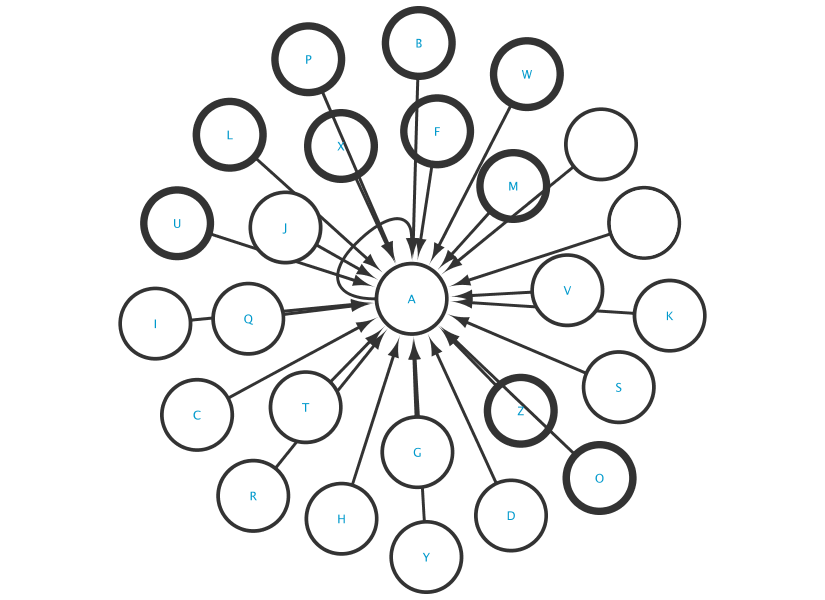

In [18]:
from IPython.display import Image

Image(url=BASE+'networks/' + str(net1['data']['SUID'])+ '/views/first.png', embed=True)

## Introduction to Cytoscape Data Model
Essentially, writing your workflow as a notebook is a programming.  To control Cytoscape efficiently from Notebooks, you need to understand basic data model of Cytoscape.  Let me explain it as a notebook...

First, let's create a data file to visualize Cytoscape data model

In [19]:
%%writefile data/model.sif
Model parent_of ViewModel_1
Model parent_of ViewModel_2
Model parent_of ViewModel_3
ViewModel_1 parent_of Presentation_A
ViewModel_1 parent_of Presentation_B
ViewModel_2 parent_of Presentation_C
ViewModel_3 parent_of Presentation_D
ViewModel_3 parent_of Presentation_E
ViewModel_3 parent_of Presentation_F

Overwriting data/model.sif


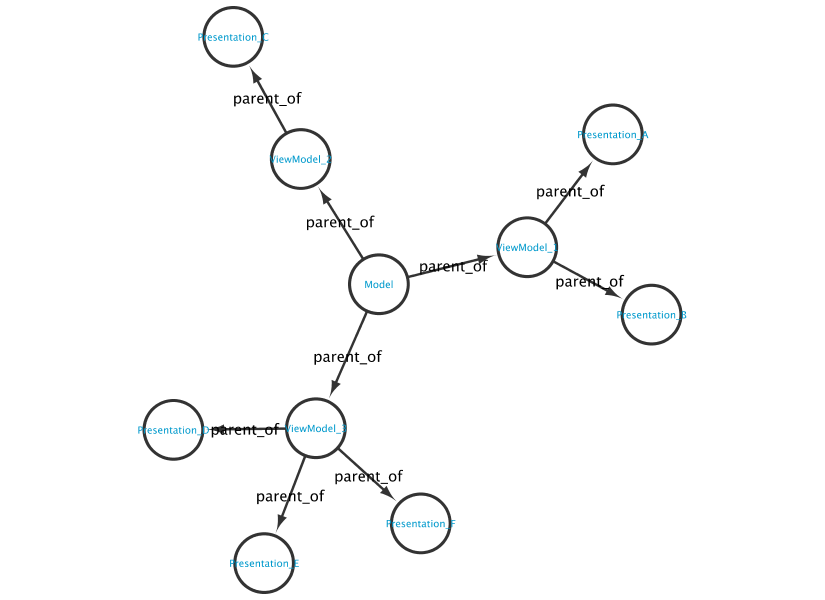

In [20]:
model = [
    'file:////Users/kono/git/vizbi-2015/tutorials/data/model.sif'
]

# Create!
res = create_from_list(model)
model_suid = res[0]['networkSUID'][0]

requests.get(BASE + 'apply/layouts/force-directed/' + str(model_suid))
Image(url=BASE+'networks/' + str(model_suid)+ '/views/first.png', embed=True)

### Mode, View Model, and Presentation

#### Model
Essentially, __Model__ in Cytoscape means networks and tables.  Internally, Model can have multiple View Models.

#### View Model
State of the view.

This is why you need to use __views__ instead of view in the API:

```
/v1/networks/SUID/views
```

However, Cytoscape 3.2.x has only one rendering engine for now, and end-users do not have access to this feature.  Until Cytoscape Desktop supports multiple renderers, best practice is just use one view per model.  To access the default view, there is a utility method _first_:

In [21]:
view_url = BASE + 'networks/' + str(model_suid) + '/views/first'
print('You can access (default) network view from this URL: ' + view_url)

You can access (default) network view from this URL: http://10.0.1.6:1234/v1/networks/16374/views/first


#### Presentation
Presentation is a stateless, actual graphics you see in the window.  A View Model can have multiple Presentations.  For now, you can assume there is always one presentation per View Model.

----

### What do you need to know as a cyREST user?
CyREST API is fairly low level, and you can access all levels of Cytoscpae data structures.  But if you want to use Cytoscape as a simple network visualization engine for IPython Notebook, here are some tips:

#### Tip 1:  Always keep SUID when you create any new object
__ALL Cytoscape objects, networks, nodes, egdes, and tables have a session unique ID, called SUID__.  When you create any new data objects in Cytoscape, it returns SUIDs.  You need to keep them as Python data objects (list, dict, amp, etc.) to access them later.

#### Tip 2: Create one view per model
Until Cytoscape Desktop fully support multiple view/presentation feature, keep it simple: one view per model.

#### Tip 3: Minimize number of API calls
Of course, there is a API to add / remove / update one data object per API call, but it is extremely inefficient!

#### 3.3.2 Prepare Network as edgelist
Edgelist is a minimalistic data format for networks and it is widely used in popular libraries including NetworkX and igraph.  Preparing edgelist in Python is straightforward.  You just need to prepare a list of edges as string like:

```
a b
b c
a c
```

In Python, there are many ways to generate string like this.  Here is a naive approach:

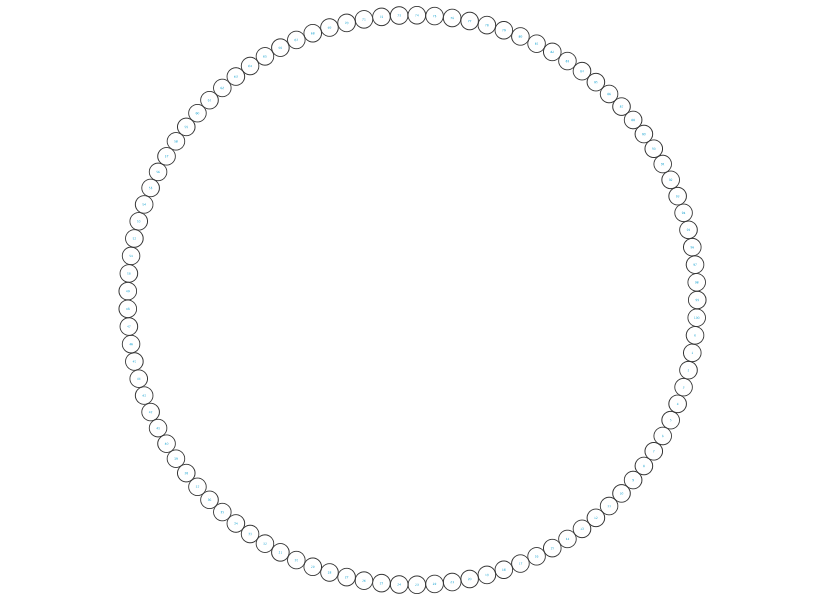

In [39]:
data_str = ''
n = 0
while n <100:
    data_str = data_str + str(n) + '\t' + str(n+1) + '\n'
    n = n + 1

# Join the first and last nodes
data_str = data_str + '100\t0\n'

# print(data_str)

res = requests.post(BASE + 'networks?format=edgelist&collection=Ring', data=data_str, headers=HEADERS)
circle_suid = res.json()['networkSUID']
requests.get(BASE + 'apply/layouts/circular/' + str(circle_suid))

Image(url=BASE+'networks/' + str(circle_suid) + '/views/first.png', embed=True)

## Discussion
In this section, we've learned how to generate networks programmatically in Python.  But for real world problems, it is not a good idea to use low level Python code to generate networks because there are lots of cool graph libraries such as NetworkX or igraph which provides high level graph APIs.  In the next session, let's use them to analyze real network data sets.

## Continues to [Lesson 2: Working with Graph Libraries]()